# EE4211 Group Project

### Members of Group 16 (by Alphabet) ###
+ **Feng Xijia**,  A0232695X, e0724494@u.nus.edu
+ **Liang Zihan**, A0232558B, e0724357@u.nus.edu
+ **Tan Tian**,   A0229561B, e0679994@u.nus.edu
+ **Yao Yuan**,   A0232893X, e0724692@u.nus.edu

# Question 3 Peak Time Analysis

### Motivations
**In this part, we analyze the user’s gas consumption habits through their daily peak gas usage times.   
Peak time contains information about users' gas usage habits. For example, some people like to use gas at night, while others prefer to use gas during the day. In addition, people's gas consumption habits may also relate to the day of the week. For instance, someone uses more on certain work days mornings while the other uses more on weekends nights due to different vocations they have. The month of the year may also have an impact on the usage of gas.  
With proper analysis on users consumption habits, gas company as well as power company etc. will be able to adapt and prepare ahead of time to provide steady run or make more profits.**

<font color=##008B8B > Remark: </font>
The entire program takes about **10** minutes to run.

---

## 1. Data preprocessing

In [1]:
import pandas as pd
from pandas import DataFrame
import warnings
from sklearn.mixture import GaussianMixture
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
import math

In [2]:
def list_add(a,b):
    
    '''
    Add the the elements with the same index in two lists to create a new list.
    
    '''
    c = []
    for i in range(len(a)):
        c.append(a[i]+b[i])
    return c

In [3]:
df = pd.read_csv('dataport-export_gas_oct2015-mar2016.csv')
df['localminute'] = df['localminute'].astype(str).str[:19]
df['localminute'] = pd.to_datetime(df['localminute'])
warnings.filterwarnings("ignore")
print(df.head(5))

          localminute  dataid  meter_value
0 2015-10-01 00:00:10     739        88858
1 2015-10-01 00:00:13    8890       197164
2 2015-10-01 00:00:20    6910       179118
3 2015-10-01 00:00:22    3635       151318
4 2015-10-01 00:00:22    1507       390354


In [4]:
def get_peaktime_ID(ID):

    '''
    Purpose:
        Get the peaktime everyday for a given user.
        
    Return:
        -df1: DataFrame. Each user has two attributes, date and peaktime.
    
    '''
    #create a new dataframe df1 to store the peak time of everydat for one ID
    df1 = pd.DataFrame(columns=['date','peaktime'])
    # Format
    # time：year-month-day-hour  value: readings
    group_ID=df.groupby(["dataid"])
    group=group_ID.get_group(ID)
    value_group=group["meter_value"]
    value=value_group.tolist()
    time_group=group["localminute"]
    time_group=pd.to_datetime(time_group)
    year=time_group.dt.year.tolist()
    month=time_group.dt.month.tolist()
    day=time_group.dt.day.tolist()
    hour=time_group.dt.hour.tolist()
    datelist=list(zip(year,month,day,hour))
    datelist=[[str(di) for di in d] for d in datelist] # convert to str, otherwise cannot use join()
    datelist=['-'.join(d) for d in datelist] # Year-month-day-hour 
    
    year1,month1,day1,hour1,value1=[[] for x in range(5)]
    
    for i in range(len(datelist)):
        # Those in Dataframe must have different timestamp without abnormal data(no jumps over 500, no decreasing)
        if i ==0 or ((datelist[i] != datelist[i-1]) and (0 <=value[i] - value[i-1]<500)):
            year1.append(year[i])
            month1.append(month[i])
            day1.append(day[i])
            hour1.append(hour[i])
            value1.append(value[i])

    datelist1=list(zip(year1,month1,day1))
    datelist1=[[str(di) for di in d] for d in datelist1] # convert to str, otherwise cannot use join()
    datelist1=['-'.join(d) for d in datelist1] # Year-month-day
    maxvalue = 0
    peaktime = 0
    for i in range(len(datelist1)):
        if i != 0 and i != len(datelist1)-1:
            if datelist1[i]==datelist1[i-1]:
                if value1[i] - value1[i-1] > maxvalue:
                    maxvalue = value1[i] - value1[i-1]
                    peaktime = hour1[i]
            else:
                # Find out if the dates are consecutive
                if abs(day1[i]-day1[i-1]) ==1 or abs(day1[i]-day1[i-1]) == 30 or abs(day1[i]-day1[i-1]) ==29 or abs(day1[i]-day1[i-1])==28:
                    df1 = df1.append({'date':datelist1[i-1],'peaktime':peaktime},ignore_index=True)
                    maxvalue = 0
                else:
                    # if not, fill the vacancies.
                    df1 = df1.append({'date':datelist1[i-1],'peaktime':peaktime},ignore_index=True)
                    maxvalue = 0
                    # If the time gap between two adjacent data is smaller than a month, then fill the vacancies.
                    # Otherwise, skip the data since they contain little information
                    if month1[i] == month1[i-1]:
                        gap = day1[i]-day1[i-1]
                        for j in range(gap-1):
                            datelost = str(year1[i-1])+'-'+str(month1[i-1])+'-'+str(day1[i-1]+j+1)
                            df1 = df1.append({'date':datelost,'peaktime':peaktime},ignore_index=True)  
                   
        elif i != 0:
             df1 = df1.append({'date':datelist1[i],'peaktime':peaktime},ignore_index=True)                 
    return df1

In [5]:
get_peaktime_ID(35)

,date,peaktime
0,2015-10-1,19
1,2015-10-2,18
2,2015-10-3,19
3,2015-10-4,19
4,2015-10-5,21
...,...,...
178,2016-3-27,20
179,2016-3-28,20
180,2016-3-29,19
181,2016-3-30,16


**There are 183 days from Oct 1st 2015 to March 31st 2016. 
We interpolate readings if the time difference between two adjacent readings is less than a month. Those whose readings have longer gap will be discarded.**

**After interpolation, there are 86 users data, each has 183 readings. Each reading represents the peak time of that day.**

In [6]:
x = df.groupby(['dataid'])
meterids = [dataid for dataid,readingList in x]
traindata = []
meterids_used = []

for i in meterids:
        a = get_peaktime_ID(i)
        peak_group=a["peaktime"]
        peak=peak_group.tolist()
        if len(peak)==183:
            traindata.append(peak);
            meterids_used.append(i);
traindata_list = traindata;
traindata = np.array(traindata) 

In [7]:
traindata

array([[19, 18, 19, ..., 19, 16,  8],
       [ 9,  8, 14, ...,  8,  8,  7],
       [22,  9, 11, ..., 23, 10,  1],
       ...,
       [ 9,  8, 17, ..., 19,  8, 15],
       [ 0, 21, 17, ..., 18, 22, 18],
       [ 5, 12,  9, ..., 13, 16, 16]])

## 2. Clustering

**Next, we apply gaussian mixture model for clustering to find users with similar consumption patterns.**

In [8]:
gmm = GaussianMixture(n_components=2)
gmm.fit(traindata)
labels = gmm.predict(traindata)

**Visualize the data distributions.**

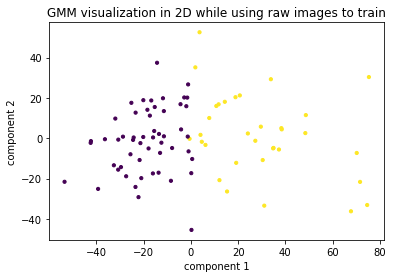

In [9]:
pca = PCA(n_components=2)
pca.fit(traindata)
visual2D = pca.transform(traindata)
plt.scatter(visual2D[:, 0], visual2D[:, 1], c=labels, s=10, cmap='viridis')
plt.title('GMM visualization in 2D while using raw images to train')
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.show()

**Calculate the mean of each cluster.**

In [10]:
means = []
for i in range(2):
    number = 0 # Record the number of data in one cluster
    sum = [0 for k in range(183)]
    for j in range(len(labels)):
        if labels [j] == i: 
            sum = list_add(sum,traindata[j])
            number+=1
    mean = [int(x/number) for x in sum]
    means.append(mean)
means = np.array(means)   

In [11]:
print(np.shape(means))
print(means)

(2, 183)
[[ 8  7 11 12  8  9  9  9  8 10 10  9 10  9 10  8 10 12 10 10 10  9 10 12
  13 13 10  9  9 10 12 13 10  9 11 10 10 11 12  9 10 11  9  9 12 10 11 13
   8  9  9 13 10  8  9  9 10 14 11 11  9  9  8  8  8  8  9  9  8  9 10 10
  11 15  7  9 13  9 10  7  9 11  9  9 10 10  9 17 10 10  9 10 11 11  9 10
   8  9  7  8 13  9  7  7  7  9  9 13  9  9  8 10 10 10  8  8  8 13  9  7
   7  8 12 11 10 12  7  8 10  7  9  7  8  9 11  9 12 12  9  9  9 10 12 13
  11 16  8  8  8  8 11 10 11 10 11 10 10 15 11 10 11 11  9 10 11 10 10 11
  11 10 13 11  9  8 11 11 10 11 12 10 11 11 10]
 [13 13 13 14 16 14 13 15 12 15 14 14 14 15 15 15 13 14 15 15 14 15 13 13
  15 15 15 14 15 14 14 15 14 16 15 12 13 14 14 15 15 14 15 16 14 15 16 16
  14 14 15 16 13 11 13 12 12 16 12 11 14 11 11 11 11 10 12 13 12 15 15 13
  15 16 13 13 15 10  9  9 10 14 12 14 14 14 12 17 11 10 11 10 14 12 11 10
  11 13 11 12 15 10  9  9  9 11 12 13 11 10  7 14 12 11  8  7 11 17  8  8
  10 11 13 15 15 14 10  9 12  9 10 10 10 13 12 15 14 15

In [12]:
def get_distance(num_cluster): 
    distance = np.zeros((num_cluster, num_cluster))
    gmm = GaussianMixture(n_components=num_cluster,random_state = 0)
    gmm.fit(traindata)
    labels = gmm.predict(traindata)
    means = []
    for i in range(num_cluster):
        number = 0 
        sum = [0 for k in range(183)]
        for j in range(len(labels)):
            if labels [j] == i: 
                sum = list_add(sum,traindata[j])
                number+=1
        mean = [int(x/number) for x in sum]
        means.append(mean) 
    means = np.array(means)
    for i in range(num_cluster): # Calculate the Euclidean distance between each mean values and store the distances into an arrary
         for j in range(num_cluster):
                if i == j:
                    distance[i][j] = 100 # For the convenience of checking the distance threshold, add something into the distance 
                                         # between a mean value and itself
                else:
                    distance[i][j] = np.sqrt(np.sum(np.square(means[i]-means[j]))) # Euclidean distance
    return distance,means,labels

In [13]:
#Find the best number of groups (input a starting value of number of groups and distance threshold)
def GMM_bestcluster(num_cluster,thresh): 
    while num_cluster > 1:
        dist = []
        d,means,labels = get_distance(num_cluster)
        for i in range(num_cluster):
            for j in range(num_cluster):
                dist.append(d[i][j])
         # If the minimum distance is larger than the threshold, then all the distances are larger than thresh, 
        # which means we can use this as the best number of clusters
        if min(dist) >= thresh:
            break
        else:
            num_cluster -= 1
    return means,labels,num_cluster # Return the mean values, distances, labels of GMM and number of clusters

**The best number to divide the users into is 2. Next, we will analyse the different pattern within these two groups.**

In [14]:
#Here, we set the threshold as 50.
means,labels,num_cluster = GMM_bestcluster(5,50)
print(num_cluster)

2


## 3. Find the peak time vs. the day of the week patterns of the two groups of users

In [15]:
Groupdata = pd.DataFrame()
Groupdata['meterid'] = meterids_used
Groupdata['label'] = labels
Groupdata['peaks'] = traindata_list # traindata_list: type: list, contains 86 sub lists, each sub list contains 183 readings.
print(Groupdata)
print(Groupdata['meterid'])

    meterid  label                                              peaks
0        35      1  [19, 18, 19, 19, 21, 20, 20, 8, 5, 3, 2, 14, 9...
1        77      0  [9, 8, 14, 20, 9, 7, 7, 8, 8, 10, 11, 9, 7, 7,...
2        94      0  [22, 9, 11, 2, 21, 22, 5, 21, 9, 23, 10, 23, 2...
3       114      0  [9, 7, 10, 19, 7, 8, 7, 12, 8, 10, 11, 6, 6, 2...
4       252      0  [10, 1, 5, 11, 2, 7, 2, 9, 5, 3, 18, 20, 1, 2,...
..      ...    ...                                                ...
81     9295      0  [10, 8, 12, 12, 20, 8, 7, 8, 8, 13, 23, 22, 8,...
82     9631      1  [7, 20, 20, 8, 8, 8, 10, 8, 8, 21, 20, 9, 10, ...
83     9729      0  [9, 8, 17, 10, 8, 8, 9, 7, 10, 11, 18, 8, 18, ...
84     9766      1  [0, 21, 17, 18, 18, 19, 19, 19, 19, 19, 19, 12...
85     9849      1  [5, 12, 9, 19, 5, 6, 7, 6, 5, 12, 21, 6, 9, 9,...

[86 rows x 3 columns]
0       35
1       77
2       94
3      114
4      252
      ... 
81    9295
82    9631
83    9729
84    9766
85    9849
Name: meterid, L

**Method 1**  
For each user, get the mean of the peaktime in the same weekday.
The shape of the data is 86 by 7. Each column represents a weekday. The first column is Thursday, since Oct 1st 2015 is Thursday.

In [16]:
datalist1 = [];
for i in range(Groupdata.shape[0]):
    peaks = Groupdata.iloc[i, 2];
    sum = [0, 0, 0, 0, 0, 0, 0]
    for day in range(182):
        idx = day%7;
        sum[idx] = sum[idx] + peaks[day];
        if(day >= 175):
            sum[idx] = sum[idx]/26; #一共26周
    datalist1.append(sum);
Groupdata['weekpeaks_mean'] = datalist1;

**Method 2**  
For each user, get the mode of the peaktime in the same weekday.
The shape of the data is 86 by 7. Each column represents a weekday. The first column is Thursday.

In [17]:
datalist2 = [];
for i in range(Groupdata.shape[0]):
    peaks = Groupdata.iloc[i, 2];
    nplist = np.array(peaks[0:182]);
    weekpeak_mode = np.reshape(nplist,[26,7]);# Total weeks: 26
    df = pd.DataFrame(weekpeak_mode);
    weekpeak_mode_x = df.mode(axis=0);
    weeklist_x = [int(i) for i in weekpeak_mode_x.values.tolist()[0]];
    datalist2.append(weeklist_x);
Groupdata['weekpeaks_mode'] = datalist2;

In [18]:
print(Groupdata)

    meterid  label                                              peaks  \
0        35      1  [19, 18, 19, 19, 21, 20, 20, 8, 5, 3, 2, 14, 9...   
1        77      0  [9, 8, 14, 20, 9, 7, 7, 8, 8, 10, 11, 9, 7, 7,...   
2        94      0  [22, 9, 11, 2, 21, 22, 5, 21, 9, 23, 10, 23, 2...   
3       114      0  [9, 7, 10, 19, 7, 8, 7, 12, 8, 10, 11, 6, 6, 2...   
4       252      0  [10, 1, 5, 11, 2, 7, 2, 9, 5, 3, 18, 20, 1, 2,...   
..      ...    ...                                                ...   
81     9295      0  [10, 8, 12, 12, 20, 8, 7, 8, 8, 13, 23, 22, 8,...   
82     9631      1  [7, 20, 20, 8, 8, 8, 10, 8, 8, 21, 20, 9, 10, ...   
83     9729      0  [9, 8, 17, 10, 8, 8, 9, 7, 10, 11, 18, 8, 18, ...   
84     9766      1  [0, 21, 17, 18, 18, 19, 19, 19, 19, 19, 19, 12...   
85     9849      1  [5, 12, 9, 19, 5, 6, 7, 6, 5, 12, 21, 6, 9, 9,...   

                                       weekpeaks_mean  \
0   [13.423076923076923, 14.192307692307692, 14.53...   
1   [9.38

**For each group, calculate all the users mode of the peaktime in the same weekday.**

   0  1  2  3  4  5  6
0  7  7  7  7  7  9  8


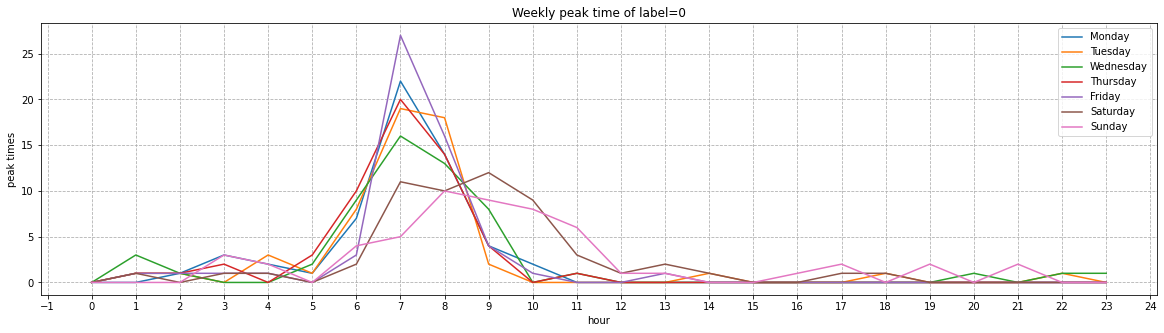

      0    1   2   3    4     5     6
0  20.0  6.0   7   6  7.0  11.0  10.0
1   NaN  NaN   8   7  8.0   NaN   NaN
2   NaN  NaN  21  19  NaN   NaN   NaN


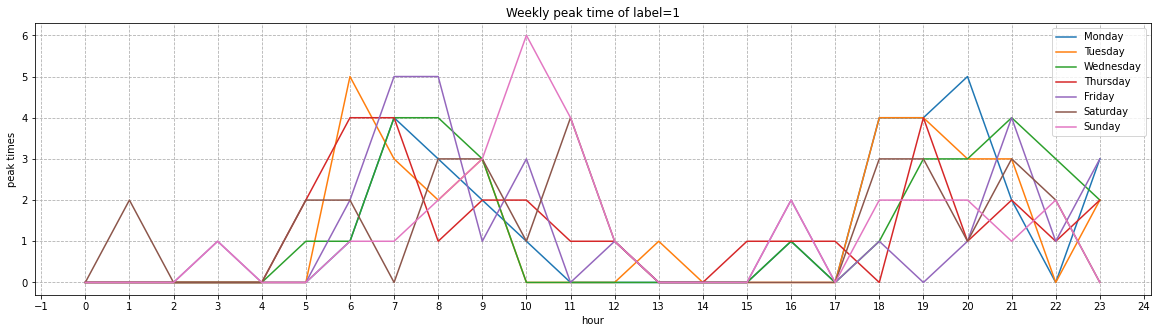

In [19]:
for label in range(2):
    labels1 = [];
    weekpeaks_label = Groupdata[Groupdata['label']==label]['weekpeaks_mode'];
    for i in range(len(weekpeaks_label)):
        weekpeak = weekpeaks_label.iloc[i,];
        labels1.append(weekpeak);
    label_numpy = np.array(labels1)
    reweek = label_numpy[:,[4,5,6,0,1,2,3]];
    df = pd.DataFrame(reweek);
    week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    weekpeak_mode_x = df.mode(axis=0);
    print(weekpeak_mode_x);
    for day in range(7):
        x = df.iloc[:, day];
        y = np.zeros(24);
        for i in range(x.shape[0]):
            peakhour = x[i];
            y[peakhour] = y[peakhour]+1;
        x_major_locator=MultipleLocator(1);
        plt.rcParams['figure.figsize']=(20,5)
        ax=plt.gca();
        ax.xaxis.set_major_locator(x_major_locator);
        plt.plot(range(24), y, markersize=1, label=week[day])
    plt.grid(ls='--')
    plt.xlabel('hour')
    plt.ylabel('peak times')
    plt.title('Weekly peak time of label='+str(label))
    plt.legend()
    plt.show()

**For each group, calculate all the users average usage of every hour in the same weekday.**

In [20]:
df = pd.read_csv('dataport-export_gas_oct2015-mar2016.csv')
df['localminute'] = df['localminute'].astype(str).str[:19]
df['localminute'] = pd.to_datetime(df['localminute'])
df['year'] = df['localminute'].dt.year
df['month'] = df['localminute'].dt.month
x = df.groupby(['dataid'])
x_month = df.groupby(['month'])

def get_week_usage(tar_month, tar_year):
    #month and corresponding days
    month_day_map  = {1:31, 2:29, 3:31, 10:31, 11:30, 12:31}
    #days = month_day_map[tar_month]
    days = 28
    MeterIds_0 = Groupdata[Groupdata['label']==0]['meterid'];
    MeterIds_1 = Groupdata[Groupdata['label']==1]['meterid'];
    MeterIds_label = [];
    MeterIds_label.append(MeterIds_0.values.tolist());
    MeterIds_label.append(MeterIds_1.values.tolist());
    
    for label in range(2):
        sum = np.zeros(24*days);
        for id in MeterIds_label[label]:
            y = x.get_group(id)
            MeterReadings = y.groupby(['year','month'])
            HouseReading = MeterReadings.get_group((tar_year,tar_month))  
            start_time = pd.Timestamp(year=tar_year, month=tar_month, day=1)
            hourly_reading = np.zeros(24*days);
            for d in range(days):
                d_rows = HouseReading[HouseReading['localminute'].dt.day == d+1].reset_index()
                if len(d_rows) > 0:
                    start_row = d_rows.iloc[0];
                else:
                    continue;
                for i in range(24):
                    rows = d_rows[d_rows['localminute'].dt.hour == i].reset_index()
                    if len(rows) > 0:
                        end_row = rows.iloc[-1];
                        hourly_reading[d*24+i] = end_row['meter_value'] - start_row['meter_value'];
                        start_row = end_row;
                    else:
                        if d+i>0:
                            hourly_reading[d*24+i] = hourly_reading[d*24+i-1]
            sum = sum + hourly_reading;
        sum = sum / len(MeterIds_label[label])
        week_sum = np.zeros([7,24]);
        for i in range(len(sum)):
            value = sum[i];
            day = math.floor(i/24) % 7 ;
            hour = i % 24;
            week_sum[day, hour] = week_sum[day, hour] + value;
        week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        for day in range(7):
            x_major_locator=MultipleLocator(1);
            plt.rcParams['figure.figsize']=(20,5)
            ax=plt.gca();
            ax.xaxis.set_major_locator(x_major_locator);
            plt.plot(range(24), week_sum[day,:], markersize=1, label=week[day])
        plt.grid(ls='--')
        plt.xlabel('hour')
        plt.ylabel('Sum usage of hour')
        plt.title('Weekly usage of label='+str(label))
        plt.legend()
        plt.show()

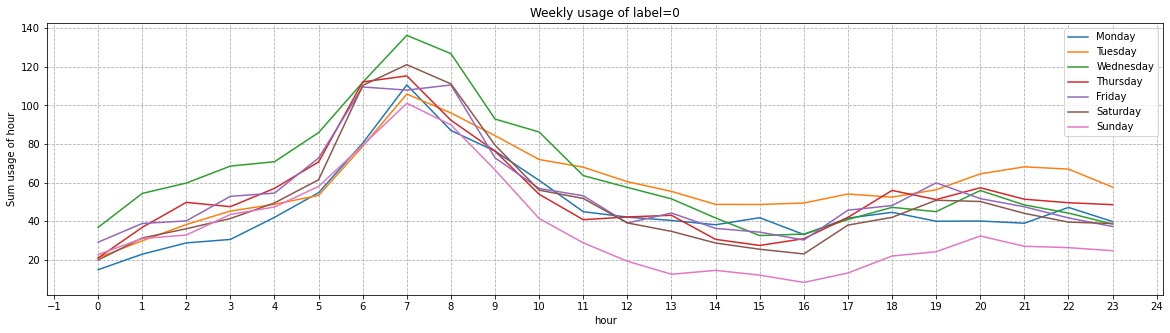

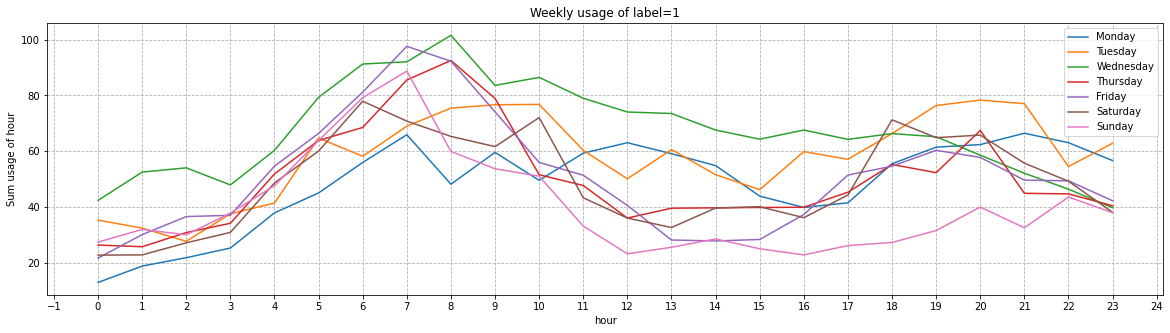

In [21]:
get_week_usage(1, 2016)

Text(0.5, 1.0, 'Peak time patterns of group 1 and 2')

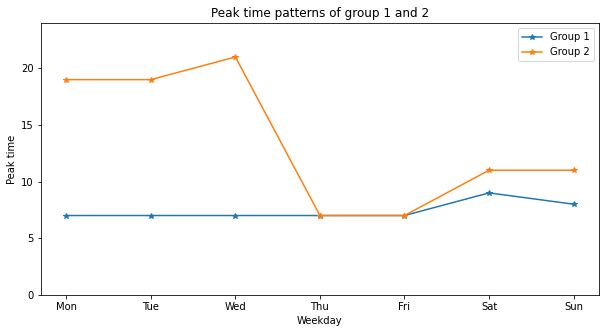

In [22]:
plt.rcParams['figure.figsize']=(10,5)
plt.ylim([0,24])
plt.plot(['Mon','Tue' ,'Wed','Thu' ,'Fri' ,'Sat' ,'Sun'],[7,7,7,7,7,9,8],'*-',label='Group 1')
plt.plot(['Mon','Tue' ,'Wed','Thu' ,'Fri' ,'Sat' ,'Sun'],[19,19,21,7,7,11,11],'*-',label='Group 2')
plt.xlabel('Weekday')
plt.ylabel('Peak time')
plt.legend()
plt.title('Peak time patterns of group 1 and 2')

## 4. Find the peak time vs. the month of the year patterns of the two groups

In [23]:
two_group=Groupdata.groupby('label')

In [24]:
def get_mode(lst):
    counts = np.bincount(lst)
    mode=np.argmax(counts)
    return mode

In [25]:
def modes_per_group(group_label):
    
    '''
    Get the peak hour modes in 6 months for all the users of the given group.
    
    Parameter:
        group_label: e.g.: 0 or 1. 
        
    Return:
        group_modes: Each row represents a user. 
                     Each columns represents a month. There are 6 columns.
    
    '''
    
    group=two_group.get_group(group_label)
    peakvalues=group['peaks'].values
    group_modes = pd.DataFrame() 
    group_mode10=[]
    group_mode11=[]
    group_mode12=[]
    group_mode01=[]
    group_mode02=[]
    group_mode03=[]

    for i in range(len(group)):

        month10=peakvalues[i][0:30]
        mode10=get_mode(month10)
        group_mode10.append(mode10)

        month11=peakvalues[i][31:60]
        mode11=get_mode(month11)
        group_mode11.append(mode11)

        month12=peakvalues[i][61:91]
        mode12=get_mode(month12)
        group_mode12.append(mode12)

        month01=peakvalues[i][92:122]
        mode01=get_mode(month01)
        group_mode01.append(mode01)

        month02=peakvalues[i][123:151]
        mode02=get_mode(month02)
        group_mode02.append(mode02)

        month03=peakvalues[i][152:182]
        mode03=get_mode(month03)
        group_mode03.append(mode03)

    group_modes['Oct']=group_mode10
    group_modes['Nov']=group_mode11
    group_modes['Dec']=group_mode12
    group_modes['Jan']=group_mode01
    group_modes['Feb']=group_mode02
    group_modes['Mar']=group_mode03
    
    return group_modes

In [26]:
group0_modes=modes_per_group(0)
group1_modes=modes_per_group(1)

In [27]:
def overall_modes_per_month(group_label):
    
    overall_modes=dict()
    group_modes=modes_per_group(group_label)
    overall_modes['Oct']=get_mode(group_modes['Oct'])
    overall_modes['Nov']=get_mode(group_modes['Nov'])
    overall_modes['Dec']=get_mode(group_modes['Dec'])
    overall_modes['Jan']=get_mode(group_modes['Jan'])
    overall_modes['Feb']=get_mode(group_modes['Feb'])
    overall_modes['Mar']=get_mode(group_modes['Mar'])
    
    return overall_modes

In [28]:
overall0=overall_modes_per_month(0)
print('The mode of each month of all users within the group 1 is: %s'%overall0)
overall1=overall_modes_per_month(1)
print('The mode of each month of all users within the group 2 is: %s'%overall1)

The mode of each month of all users within the group 1 is: {'Oct': 8, 'Nov': 7, 'Dec': 7, 'Jan': 8, 'Feb': 7, 'Mar': 7}
The mode of each month of all users within the group 2 is: {'Oct': 19, 'Nov': 20, 'Dec': 7, 'Jan': 7, 'Feb': 6, 'Mar': 7}


Text(0.5, 1.0, 'Peak time patterns of group 1 and 2')

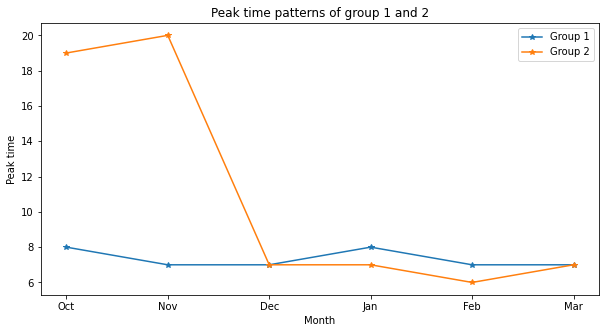

In [29]:
plt.plot(overall0.keys(),overall0.values(),'*-',label='Group 1')
plt.plot(overall1.keys(),overall1.values(),'*-',label='Group 2')
plt.xlabel('Month')
plt.ylabel('Peak time')
plt.legend()
plt.title('Peak time patterns of group 1 and 2')

In [30]:
def get_month_usage(tar_label):
    #month and corresponding days
    month_day_map  = {1:31, 2:29, 3:31, 10:31, 11:30, 12:31}
    month_year_map  = {1:2016, 2:2016, 3:2016, 10:2015, 11:2015, 12:2015}
    MeterIds_0 = Groupdata[Groupdata['label']==0]['meterid'];
    MeterIds_1 = Groupdata[Groupdata['label']==1]['meterid'];
    MeterIds_label = [];
    MeterIds_label.append(MeterIds_0.values.tolist());
    MeterIds_label.append(MeterIds_1.values.tolist());
    ids = MeterIds_label[tar_label];
    
    for tar_month in [10,11,1,2,3]:
        y = x_month.get_group(tar_month);
        MeterReadings = y.groupby(['dataid'])
        days = month_day_map[tar_month]
        tar_year = month_year_map[tar_month]
        sum = np.zeros(24*days);
        for meterid in ids:
            HouseReading = MeterReadings.get_group(meterid);
            start_time = pd.Timestamp(year=tar_year, month=tar_month, day=1);
            hourly_reading = np.zeros(24*days);
            for d in range(days):
                d_rows = HouseReading[HouseReading['localminute'].dt.day == d+1].reset_index()
                if len(d_rows) > 0:
                    start_row = d_rows.iloc[0];
                else:
                    continue;
                for i in range(24):
                    rows = d_rows[d_rows['localminute'].dt.hour == i].reset_index()
                    if len(rows) > 0:
                        end_row = rows.iloc[-1];
                        hourly_reading[d*24+i] = end_row['meter_value'] - start_row['meter_value'];
                        start_row = end_row;
                    else:
                        if d+i>0:
                            hourly_reading[d*24+i] = hourly_reading[d*24+i-1]
            sum = sum + hourly_reading;
        sum_month = sum/len(ids);
        month_sum = np.zeros(24);
        for i in range(len(sum_month)):
            value = sum_month[i];
            hour = i % 24;
            month_sum[hour] = month_sum[hour] + value;
        x_major_locator=MultipleLocator(1);
        plt.rcParams['figure.figsize']=(20,5)
        ax=plt.gca();
        ax.xaxis.set_major_locator(x_major_locator);
        plt.plot(range(24), month_sum, markersize=1, label=tar_month)
        
    plt.grid(ls='--')
    plt.xlabel('hour')
    plt.ylabel('Sum usage of hour')
    plt.title('Monthly usage of label='+str(tar_label))
    plt.legend()
    plt.show()

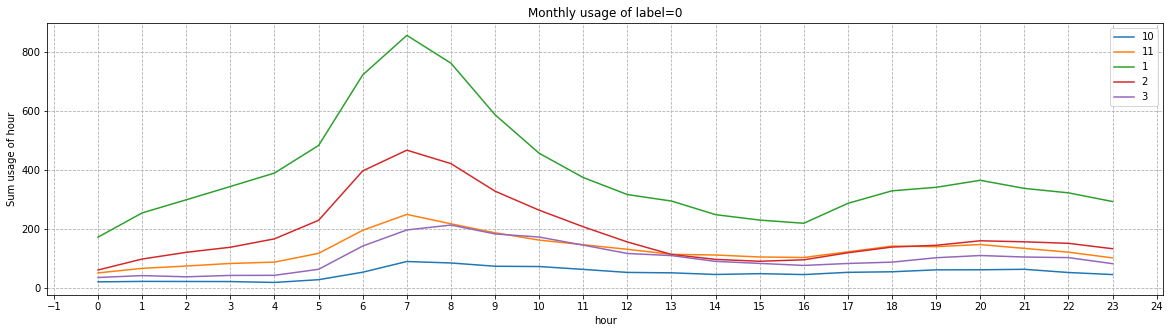

In [31]:
get_month_usage(0)

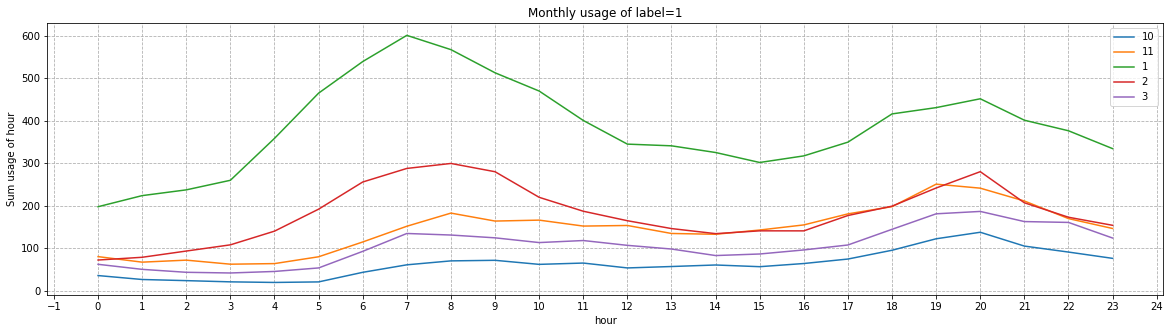

In [32]:
get_month_usage(1)

**From the plot we can find that people from group 1 prefer to consume more gas in the morning during each month, group 2 uses more in the evening in October and November.**